# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
import platform

# Check the OS of the system
os_type = platform.system()

# Download the dataset based on the OS
if os_type == 'Windows':
    !curl -L -o Task01_BrainTumour_2D.tar.gz https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
else:
    !wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2025-02-16 21:21:06--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1 [following]
--2025-02-16 21:21:06--  https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc96b34f91266af06db1a7e568fd.dl.dropboxusercontent.com/cd/0/inline/CkTN0qLUwDiypDlP1-Gck6AMtdghhnCdY8KO1q1uYUCl4Sh5U0k4JUFPBLel33DOEoG-wGTtg-r7aP7KrjTlvvwy8oABfnYWOzmcPv51GNPhUybXnjtfnF_n9aQGmP7tw8k/file# [following]
--2025-02-16 21:21:07--  https://uc96b34f91266af06db1a7e568fd.dl.dropbo

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

<ipython-input-3-4150afcbb206>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(train_images_path, image_names[idx]))
<ipython-input-3-4150afcbb206>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(os.path.join(train_labels_path, label_names[idx]))


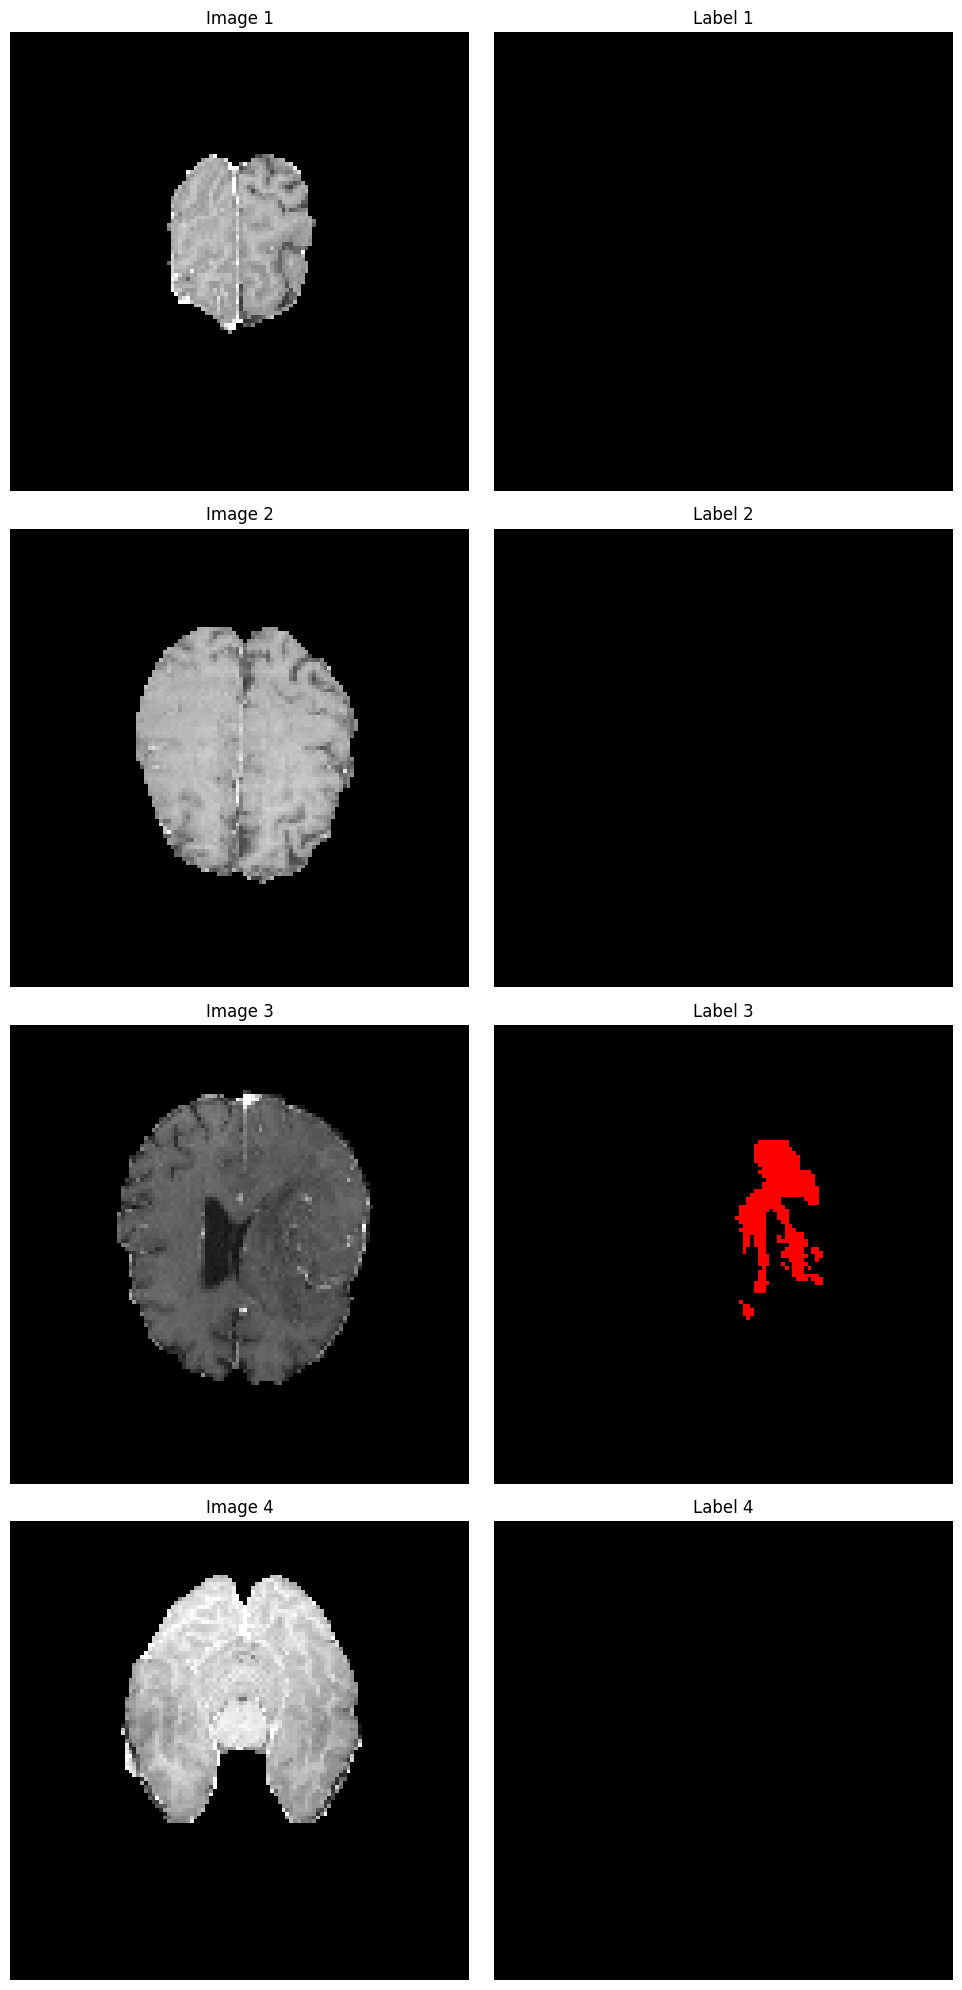

In [3]:
### Insert your code ###
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

# Suggested colour maps
image_cmap = 'gray'
label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

# Load the training images and labels
train_images_path = 'Task01_BrainTumour_2D/training_images'
train_labels_path = 'Task01_BrainTumour_2D/training_labels'
image_names = sorted(os.listdir(train_images_path))
label_names = sorted(os.listdir(train_labels_path))

# Randomly select 4 images
random_indices = random.sample(range(len(image_names)), 4)

for i, idx in enumerate(random_indices):
    # Read the image and label
    image = imageio.imread(os.path.join(train_images_path, image_names[idx]))
    label = imageio.imread(os.path.join(train_labels_path, label_names[idx]))

    # Display the image
    axes[i, 0].imshow(image, cmap=image_cmap)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    # Display the label
    axes[i, 1].imshow(label, cmap=label_cmap)
    axes[i, 1].set_title(f'Label {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        indices = random.sample(range(len(self.images)), batch_size)
        for i in indices:
            images.append(self.images[i])
            labels.append(self.labels[i])
        images = np.expand_dims(np.array(images), axis=1)  # Add channel dimension
        labels = np.array(labels)
        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [5]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        n //= 2  # 64
        self.upconv3 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv3dec = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 32
        self.upconv2 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv2dec = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 16
        self.upconv1 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv1dec = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.final_conv = nn.Conv2d(n, output_channel, kernel_size=1)
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.conv3dec(torch.cat([self.upconv3(x), conv3_skip], dim=1))
        x = self.conv2dec(torch.cat([self.upconv2(x), conv2_skip], dim=1))
        x = self.conv1dec(torch.cat([self.upconv1(x), conv1_skip], dim=1))
        x = self.final_conv(x)
        ### End of your code ###
        return x


## 4. Train the segmentation model.

In [6]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000  # 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    if it % 10 == 0:
        print('Iteration {0} | Training loss: {1:.4f} | Time: {2:.2f}s'.format(it, loss.item(), time.time() - start_iter))
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
            test_logits = model(test_images)
            test_loss = criterion(test_logits, test_labels)
            print('Iteration {0} | Test loss: {1:.4f}'.format(it, test_loss.item()))
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-4-61a4c4c32391>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-4-61a4c4c32391>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


Iteration 10 | Training loss: 1.4396 | Time: 0.06s
Iteration 20 | Training loss: 1.2650 | Time: 0.06s
Iteration 30 | Training loss: 1.1448 | Time: 0.05s
Iteration 40 | Training loss: 1.0438 | Time: 0.06s
Iteration 50 | Training loss: 0.9574 | Time: 0.06s
Iteration 60 | Training loss: 0.8825 | Time: 0.06s
Iteration 70 | Training loss: 0.7990 | Time: 0.06s
Iteration 80 | Training loss: 0.7291 | Time: 0.06s
Iteration 90 | Training loss: 0.6651 | Time: 0.06s
Iteration 100 | Training loss: 0.5911 | Time: 0.06s
Iteration 100 | Test loss: 0.6644
Iteration 110 | Training loss: 0.5381 | Time: 0.06s
Iteration 120 | Training loss: 0.4915 | Time: 0.06s
Iteration 130 | Training loss: 0.4400 | Time: 0.06s
Iteration 140 | Training loss: 0.3922 | Time: 0.06s
Iteration 150 | Training loss: 0.3581 | Time: 0.06s
Iteration 160 | Training loss: 0.3281 | Time: 0.06s
Iteration 170 | Training loss: 0.3199 | Time: 0.06s
Iteration 180 | Training loss: 0.2612 | Time: 0.06s
Iteration 190 | Training loss: 0.2474 |

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

<ipython-input-7-1d2ea1add527>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_dir, 'model_10000.pt')))


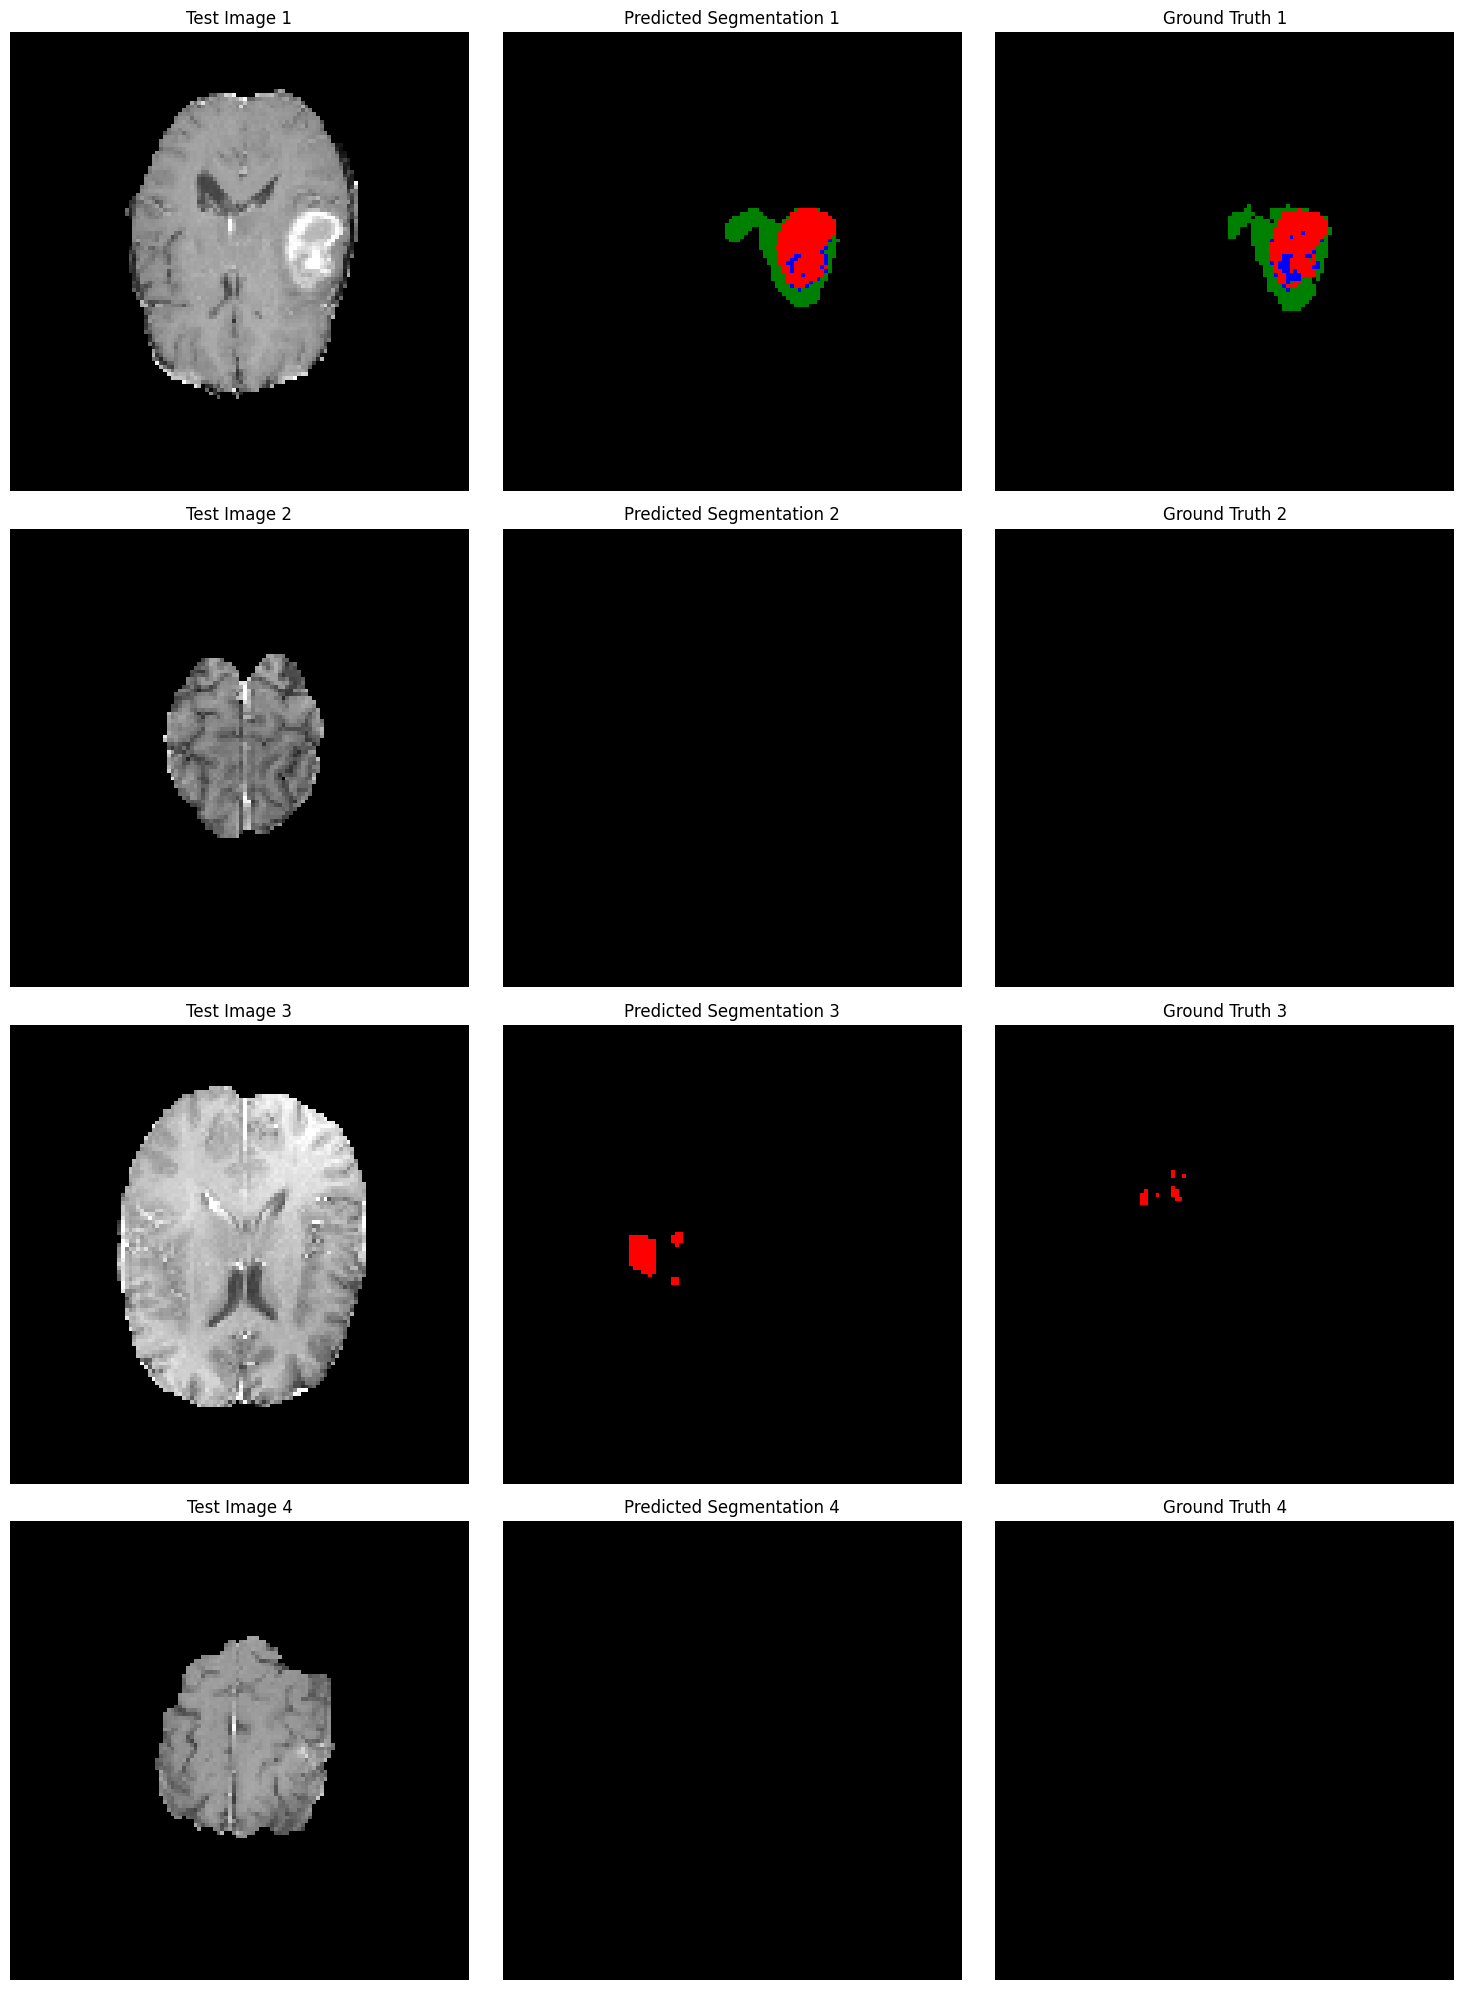

In [7]:
### Insert your code ###
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Suggested colour maps
image_cmap = 'gray'
label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

# Randomly select 4 test images
random_indices = random.sample(range(len(test_set.images)), 4)

# Load the trained model
model.load_state_dict(torch.load(os.path.join(model_dir, 'model_10000.pt')))
model = model.to(device)

for i, idx in enumerate(random_indices):
    # Read the image and label
    image = test_set.images[idx]
    label = test_set.labels[idx]

    # Get the model prediction
    model.eval()
    with torch.no_grad():
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
        pred = model(image_tensor)
        pred = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

    # Display the test image
    axes[i, 0].imshow(image, cmap=image_cmap)
    axes[i, 0].set_title(f'Test Image {i+1}')
    axes[i, 0].axis('off')

    # Display the model prediction
    axes[i, 1].imshow(pred, cmap=label_cmap)
    axes[i, 1].set_title(f'Predicted Segmentation {i+1}')
    axes[i, 1].axis('off')

    # Display the ground truth label
    axes[i, 2].imshow(label, cmap=label_cmap)
    axes[i, 2].set_title(f'Ground Truth {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The trained model performs moderately well, as indicated by its low training and test loss. It accurately identifies brain abnormalities and their locations in most cases but occasionally misclassifies some regions and introduces minor errors at tumor boundaries. To enhance its performance and ensure suitability for clinical deployment, several improvements can be made:

1. Data Augmentation: Enhance the model's robustness by applying transformations such as rotations, flips, intensity variations, and noise injection to increase the diversity of the training data.

2. Hyperparameter Optimisation: Fine-tune learning rates, batch sizes, and architectural parameters (e.g., number of filters in the U-Net) to achieve the best performance.

3. Cross-Validation: Implement k-fold cross-validation to improve generalisation and prevent overfitting to specific datasets.

4. Post-Processing: Use techniques like conditional random fields (CRFs) or morphological operations to refine segmentation and reduce boundary errors.

5. Ensemble Learning: Combine predictions from multiple models to enhance accuracy and reliability.

6. Transfer Learning: Utilise pre-trained models trained on similar medical imaging tasks and fine-tune them for brain tumor segmentation to leverage learned feature representations.

7. Clinical Validation: Test the model on a larger and diverse dataset with expert annotations to ensure its effectiveness across different patient populations.

8. Model Interpretability: Develop explainability methods (e.g., saliency maps or Grad-CAM) to help clinicians understand the model's predictions and build trust in its recommendations.